In [67]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gatspy
from astropy.io import ascii
from StringIO import StringIO
import pylab
import operator

import itertools

import pandas as pd
import sklearn
import seaborn as sns

from sklearn.decomposition import PCA 
from sklearn import linear_model
from sklearn.cross_validation import *
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
#import a few modules from scikit-learn
from sklearn import svm, linear_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree

from collections import defaultdict

from scipy import optimize

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline

#DEFINE PI
pi = np.pi

fig_path = '../slope_project/' #set directory to save all figures
sns.set_style('ticks') #seaborn figure preferences
sns.set_context('paper', font_scale = 1.5)

In [43]:
def train_and_evaluate(clf, X_train, y_train, verbose = False):
    clf.fit(X_train, y_train)

    #create a k-fold cross validation iterator of k = 5 folds
    cv = KFold(X_train.shape[0], 5, shuffle = True)
    scores = cross_val_score(clf, X_train, y_train, cv = cv)

    if verbose == True:
        print("Coefficient of determination on training set:", clf.score(X_train, y_train))
        print("Average coefficient of determination using 5-fold crossvalidation:", np.mean(scores))
    
    return clf.score(X_train, y_train), np.mean(scores)

def OneDimensionalROC(clf, X_train, y_train, X_test):
    
    pylab.rcParams['figure.figsize'] = (6.0, 6.0)
    
    #debate differences between decision function and predict_proba?
    #they are inverse monotone
    
    #y_score = clf.fit(X_train, y_train).decision_function(X_test)
    y_score = clf.fit(X_train, y_train).predict_proba(X_test).T[1]

    n_classes = 1 #this is a single class classification problem

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc, y_score

In [3]:
d = pd.read_csv('pool_dataset.csv')

In [4]:
pick_cor = d.drop(['Unnamed: 0','spr','yr'], axis = 1).T.as_matrix()

In [5]:
names = list(d.drop(['Unnamed: 0','spr','yr'], axis = 1).columns)
#remove Soblocoa from the pool
names.remove('Soblocoa')
d['fav'] = d[names].T.sum() #count number of favorite picks for each game

In [6]:
def PlotCorr(cor, labels):
    
    #labels = ['Min1','Max1','Min2','Max2']
    
    fig = plt.figure()
    plt.imshow(cor, interpolation = 'nearest')
    plt.xticks(range(len(labels)), labels, rotation = 90)
    plt.yticks(range(len(labels)), labels)
    
    #for i in range(4):
    #    for j in range(4):
    #        plt.gca().annotate(str(cor[i][j].round(2)), xy = (i - 0.2,j + 0.1))
    sns.despine()
    
    return fig

In [105]:
def model(x):
    return 1 / (1 + np.exp(-x))

def LogLikelihood(x, clf):
    return model(x * clf.coef_ + clf.intercept_).ravel()

def ComputeExpectation(spread, model_list, verbose = False):

    favs_list = [] #total number of favorites

    for model in model_list:
        if verbose == True:
            print(model + ' : ' + str(LogLikelihood(spread, model_list[model])))
        favs_list.append(LogLikelihood(spread, model_list[model]))
    
    total_favs = sum(np.ravel(favs_list))
    
    if verbose == True:
        print('Total Favorites: ' + str(total_favs))

    possible_fav_points = len(model_list.keys()) - total_favs
    possible_und_points = total_favs
    
    if verbose == True:
        print('Poss. Fav. Points: ' + str(possible_fav_points))
        print('Poss. Und. Points: ' + str(possible_und_points))

    prob_fav_win = -0.026*(spread) + 0.5 #calculate probability favorite wins, based on spread
    prob_und_win =  1.0 - (-0.026*(spread) + 0.5) #calculate probability favorite wins, based on spread
    
    if verbose == True:
        print('Prob. Fav. Win: ' + str(prob_fav_win))
        print('Prob. Und. Win: ' + str(prob_und_win))
            
    expect_fav_points = possible_fav_points*prob_fav_win
    expect_und_points = possible_und_points*prob_und_win
    
    pick = []
    
    if expect_fav_points > expect_und_points:
        pick = 1
    elif expect_fav_points <= expect_und_points:
        pick = 0
    
    return expect_fav_points, expect_und_points, pick

In [8]:
cor_fig = PlotCorr(np.corrcoef(pick_cor), names)

NameError: name 'pick_cor' is not defined

In [108]:
model_dict = defaultdict()

for name in names:
    X_train, X_test, y_train, y_test = train_test_split(d[['spr']], d[[name]], test_size = 0.75)
    log_clf = linear_model.LogisticRegression(C = 1e4)
    log_clf.fit(X_train, np.ravel(y_train))
    
    model_dict[name] = log_clf

#model_dict['Jane'] = model_dict['Miles'] #model Jane as Miles

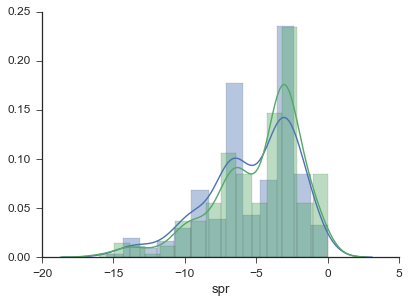

In [34]:
sns.distplot(d['spr'][d['yr'] == 2014])
sns.distplot(d['spr'][d['yr'] == 2015])
sns.despine()

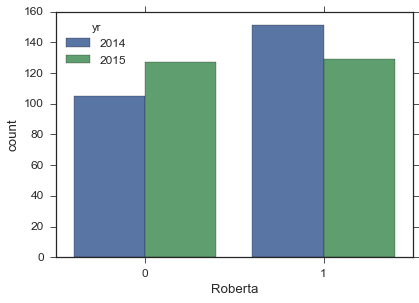

In [37]:
sns.countplot(data = d, x = 'Roberta', hue = 'yr')

In [69]:
#split data by year into training and testing sets.
train = d[d['yr'] == 2014]
test = d[d['yr'] == 2015]

y_train, X_train = train['Miles'], train[['spr']]
y_test, X_test = test['Miles'], test[['spr']]

In [70]:
#initilize candidate models, and store the in a model dictionary
models = {'SVC': svm.SVC(probability = True, C = 0.01),\
          'Logistic Regression': linear_model.LogisticRegression(C = 0.01),\
          #'ExtraTrees': ExtraTreesClassifier(n_estimators = 250, random_state = 0),\
          'AdaBoost_DT': AdaBoostClassifier(n_estimators = 1000, random_state = 0),\
         'Random Forest': RandomForestClassifier(n_estimators = 250, max_depth = None, min_samples_split = 1)}

In [71]:
for model in models: #for every model in our model dictionary
    print(model + ':')
    train_and_evaluate(models[model], X_train, y_train, verbose = True) #train the model on the data
    print('\n')

AdaBoost_DT:
Coefficient of determination on training set: 0.73828125
Average coefficient of determination using 5-fold crossvalidation: 0.6604826546


SVC:
Coefficient of determination on training set: 0.68359375
Average coefficient of determination using 5-fold crossvalidation: 0.68371040724


Logistic Regression:
Coefficient of determination on training set: 0.6796875
Average coefficient of determination using 5-fold crossvalidation: 0.679864253394


Random Forest:
Coefficient of determination on training set: 0.73828125
Average coefficient of determination using 5-fold crossvalidation: 0.659954751131




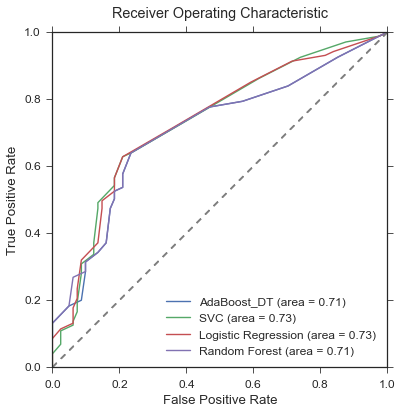

In [72]:
for clf in models: #for every model in our dictionary of models
    
    fpr, tpr, roc_auc, _ = OneDimensionalROC(models[clf], X_train, y_train, X_test)
    
    plt.plot(fpr, tpr, label = str(clf) + ' (area = %0.2f)' % roc_auc)
    plt.title('Receiver Operating Characteristic', y = 1.03)
    plt.gca().set_aspect('equal')
    plt.plot([0,1],[0,1], c  = 'grey', ls = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
plt.savefig('Ensemble_ROC.png', dpi = 300, fmt = 'png')

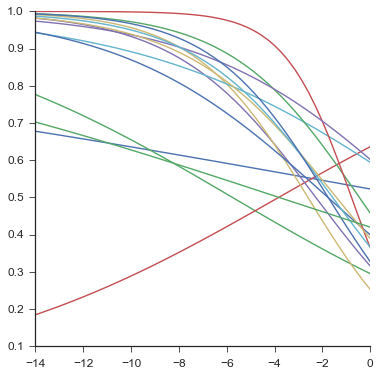

In [110]:
for name in names:
    plt.plot(np.linspace(-14,0), LogLikelihood(np.linspace(-14,0), model_dict[name]), label = name)
    sns.despine()

In [111]:
expects_fav = []
expects_und = []

for i in np.linspace(-16,0,100):
    expects_fav.append(ComputeExpectation(i,model_dict, verbose = False)[0])
    expects_und.append(ComputeExpectation(i,model_dict, verbose = False)[1])

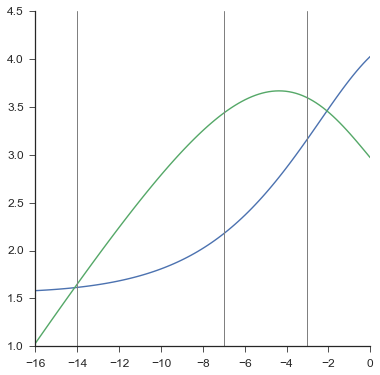

In [112]:
plt.plot(np.linspace(-16,0,100), expects_fav)
plt.plot(np.linspace(-16,0,100), expects_und)
plt.axvline(-3, lw = 1, color = 'gray')
plt.axvline(-7, lw = 1, color = 'gray')
plt.axvline(-14, lw = 1, color = 'gray')
sns.despine()

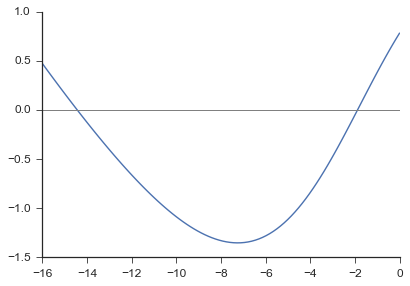

In [13]:
plt.plot(np.linspace(-16,0,100), np.array(expects_fav) - np.array(expects_und))
plt.axhline(0, lw = 1, c = 'gray')
sns.despine()

In [17]:
def SimulateSpreads(spreaddist, length):
    g_spreads = spreaddist[np.random.randint(0,len(spreaddist), length)]
    return np.array(g_spreads)

In [18]:
def MakePick(spread, model_dict):
    
    pick = defaultdict()
    
    for model in model_dict:
        
        if np.random.uniform(0,1) <= LogLikelihood(spread, model_dict[model]):
            pick[model] = 1
        else:
            pick[model] = 0
            
    return pick

def SimulateGame(spread):
    
    if np.random.uniform(0,1) <= -0.026*(spread) + 0.5:
        winner = 1
    else:
        winner = 0
    
    return winner

In [19]:
pix = []
games = []
franklona = []

for spread in SimulateSpreads(d['spr'],16):    
    pix.append(MakePick(spread, model_dict))
    games.append(SimulateGame(spread))
    franklona.append(ComputeExpectation(spread,model_dict)[-1])
    
pix = pd.DataFrame(pix)
games = pd.DataFrame(games)

pix['Franklona'] = franklona #add Franklona back into the pool

In [20]:
final_points = []

und_pts = pix.sum(axis = 1)
fav_pts = len(pix.T) - und_pts

for i in range(len(pix)):
    for game in pix.loc[i]:
        if (game == games.loc[i][0]) & (game == 1):
            final_points.append(fav_pts)
        elif (game == games.loc[i][0]) & (game == 0):
            final_points.append(und_pts)
        else:
            final_points.append(0)

In [102]:
'''
WEEK 4:
week_spreads = [-7.0,-2.5,-9.0,-4.5,-1.5,-3.0,-3.0,-6.5,-3.5,-3.0,-3.0,-3.5,-8.0,-5.5,-4.0]

week_favs = ["Cincinnati", "Indianapolis", "Washington", "New England",\
            "Seattle", "Carolina", "Detroit", "Houston", "Baltimore", "Denver",\
            "Dallas", "San Diego", "Arizona", "Pittsburgh", "Minnesota"]

week_unds = ["Miami", "Jacksonville", "Cleveland", "Buffalo", "NY Jets", "Atlanta", "Chicago",\
             "Tennessee", "Oakland", "Tampa Bay", "San Francisco", "New Orleans","Los Angeles",\
             "Kansas City","NY Giants"]

WEEK 5:
week_spreads = [-4.5,-6.0,-3.5,-10.5,-7.0,-4.0,-3.0,-4.5,-6.0,-2.5,-4.0,-1.0,-7.0,-6.0]

week_favs = ["Arizona", "Minnesota", "Miami", "New England",\
            "Pittsburgh", "Baltimore", "Philadelphia", "Indianapolis", "Denver", "Los Angeles",\
            "Oakland", "Cincinnati", "Green Bay", "Carolina"]

week_unds = ["San Francisco", "Houston", "Tennessee", "Cleveland", "NY Jets", "Washington", "Detroit",\
             "Chicago", "Atlanta", "Buffalo", "San Diego", "Dallas","NY Giants",\
             "Tampa Bay"]

WEEK 6:

week_spreads = [-3.5,-9.0,-3.0,-3.0,-7.5,-2.5,-8.0,-3.5,-7.0,-2.0,-1.0,-6.0,-4.0,-3.0, -8.0]

week_favs = ["Denver", "New England", "NY Giants", "Carolina",\
            "Pittsburgh", "Chicago", "Buffalo", "Detroit", "Tennessee", "Philadelphia",\
            "Oakland", "Seattle", "Green Bay", "Houston", "NY Jets"]

week_unds = ["San Diego", "Cincinnati", "Baltimore", "New Orleans", "Miami", "Jacksonville", "San Francisco",\
             "Los Angeles", "Cleveland", "Washington", "Kansas City", "Atlanta","Dallas",\
             "Indianapolis", "NY Jets"]
             
WEEK 7: 



week_spreads = [-7.5,-3.0,-2.5,-6.5,-1.5,-10.0,-3.0,-1.0,-2.5,-1.0,-6.5,-2.0,-7.0,-2.0,-7.5]

week_favs = ["Green Bay", "NY Giants", "Minnesota", "Kansas City",\
            "Detroit", "Cincinnati", "Buffalo", "Jacksonville", "Tennessee", "NY Jets",\
            "Atlanta", "Tampa Bay", "New England", "Arizona", "Denver"]

week_unds = ["Chicago", "Los Angeles", "Philadelphia", "New Orleans", "Washington", "Cleveland", "Miami",\
             "Oakland", "Indianapolis", "Baltimore", "San Diego", "San Francisco","Pittsburgh",\
             "Seattle", "Houston"]

WEEK 8:
   
week_spreads = [-3.5,-3.0,-3.0,-2.5,-2.5,-6.0,-4.0,-1.0,-2.5,-5.0,-2.5,-4.5,-6.0]

week_favs = ["Tennessee", "Cincinnati", "Atlanta",\
            "Houston", "Seattle", "New England", "NY Jets", "Tampa Bay", "Kansas City",\
            "Denver", "Carolina", "Dallas", "Minnesota"]

week_unds = ["Jacksonville", "Washington", "Green Bay", "Detroit", "New Orleans", "Buffalo", "Cleveland",\
             "Oakland", "Indianapolis", "San Diego", "Arizona","Philadelphia","Chicago"]
             
WEEK 9:

week_spreads = [-3.5,-7.5,-6.0,-2.5,-7.5,-3.5,-0.0,-3.5,-3.0,-7.0,-5.0,-0.0,-7.0]

week_favs = ['Atlanta','Kansas City','Minnesota', 'NYGiants', 'Dallas', 'Miami','Baltimore','New Orleans',\
            'Carolina','Green Bay','San Diego', 'Oakland', 'Seattle']

week_unds = ["Tampa Bay", "Jacksonville", "Detroit", "Philadelphia", "Cleveland", "NY Jets", "Pittsburgh",\
             "San Francisco", "Los Angeles", "Indianapolis", "Tennessee","Denver",\
             "Buffalo"]


WEEK 10:

week_spreads = [-8.0,-1.5,-3.0,-3.0,-1.5,-2.0,-2.5,-2.5,-1.5,-4.0,-13.5,-2.5,-7.5,-0.0]

week_favs = ['Baltimore','Jacksonville','Carolina', 'NewOrleans', 'NYJets', 'Atlanta','Washington','Green Bay',\
            'Chicago','San Diego','Arizona', 'Pittsburgh', 'New England', 'NYGiants']

week_unds = ["Cleveland", "Houston", "Kansas City", "Denver", "Los Angeles", "Philadelphia", "Minnesota",\
             "Tennessee", "Tampa Bay", "Miami", "San Francisco","Dallas",\
             "Seattle", "Cincinnati"]
             
WEEK 11:



week_spreads = [-3.5,-3.0,-6.5,-7.5,-7.5,-0.0,-3.0,-7.0,-8.0,-1.0,-13.0,-6.5,-2.5,-5.5]

week_favs = ['Carolina','Indianapolis','Detroit', 'KansasCity', 'NYGiants', 'Minnesota','Cincinnati','Dallas',\
            'Pittsburgh','Miami','NewEngland', 'Seattle', 'Washington', 'Oakland']

week_unds = ["NewOrleans", "Tennessee", "Jacksonville", "TampaBay", "Chicago", "Arizona", "Buffalo",\
             "Baltimore", "Cleveland", "LosAngeles", "SanFrancisco","Philadelphia","GreenBay",\
             "Houston"]
    
    
WEEK 12:
      


week_spreads = [-3.0,-3.5,-4.5,-6.5,-1.0,-6.0,-1.0,-7.0]

week_favs = ['Dallas','Denver','Atlanta', 'GreenBay', 'Cincinnati', 'New Orleans','Chicago', 'New England',\
            'Baltimore','Oakland','SanDiego', 'Arizona', 'Pittsburgh', 'Seattle', 'Indianapolis']

week_unds = ["Minnesota", "Jacksonville", "KansasCity", "Houston", "Philadelphia", "Detroit", "SanFrancisco",\
             "LosAngeles", "Miami", "Buffalo", "TampaBay","Washington","NYGiants",\
             "Carolina", "NYJets"]

WEEK 13:


week_spreads = [-3.0,-1.0,-1.0,-6.0,-6.0,-2.0,-1.5,-8.0,-3.5,-2.5,-1.0,-2.5,-2.5,-6.0,-3.0,-7.0]

week_favs = ['KansasCity', 'Tennessee', 'Carolina', 'Indianapolis', 'Cincinnati', 'Pittsburgh',\
            'Miami', 'Detroit', 'Minnesota', 'TampaBay', 'Washington', 'SanFrancisco', 'Seattle',\
            'Atlanta', 'Dallas', 'NewEngland']

week_unds = ['Oakland','Denver','SanDiego','Houston','Cleveland','Buffalo','Arizona','Chicago',\
            'Jacksonville','NewOrleans','Philadelphia','NYJets','GreenBay','LosAngeles','NYGiants','Baltimore']
            
WEEK 14:

'''

week_spreads = [-15.0,-2.5,-7.0,-4.5,-6.0,-6.5,-4.0,-10.0,-5.5,-6.0,-2.5,-13.5,-3.0,-3.0,-3.5,-4.5]

week_favs = ['Seattle', 'Miami', 'Dallas', 'NYGiants', 'Baltimore', 'GreenBay',\
            'Minnesota', 'Buffalo', 'KansasCity', 'Houston', 'Arizona', 'Atlanta', 'NewEngland',\
            'Oakland', 'Pittsburgh', 'Washington']

week_unds = ['LosAngeles','NYJets','TampaBay','Detroit','Philadelphia','Chicago','Indianapolis','Cleveland',\
            'Tennessee','Jacksonville','NewOrleans','SanFrancisco','Denver','SanDiego','Cincinnati','Carolina']
            



def PrintPicks(spreads, favs, unds):

    fav_boolean = []

    for spread in spreads: #for every spread during the week   
        fav_boolean.append(ComputeExpectation(spread,model_dict)[-1])
    
    print(fav_boolean)
    
    pick_names = []
    
    for i in range(len(fav_boolean)):
        if fav_boolean[i] == 1:
            pick_names.append(week_favs[i])
        elif fav_boolean[i] == 0:
            pick_names.append(week_unds[i])
            
    return(pick_names)

In [103]:
print(len(week_unds))
print(len(week_favs))
print(len(week_spreads))

16
16
16


In [100]:
pd.DataFrame([week_favs, week_spreads, week_unds]).T

,0,1,2
0,Seattle,-15,LosAngeles
1,Miami,-2.5,NYJets
2,Dallas,-7,TampaBay
3,NYGiants,-4.5,Detroit
4,Baltimore,-6,Philadelphia
5,GreenBay,-6.5,Chicago
6,Minnesota,-4,Indianapolis
7,Buffalo,-10,Cleveland
8,KansasCity,-5.5,Tennessee
9,Houston,-6,Jacksonville


In [113]:
PrintPicks(week_spreads, week_favs, week_unds)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


['Seattle',
 'NYJets',
 'TampaBay',
 'Detroit',
 'Philadelphia',
 'Chicago',
 'Indianapolis',
 'Cleveland',
 'Tennessee',
 'Jacksonville',
 'NewOrleans',
 'SanFrancisco',
 'Denver',
 'SanDiego',
 'Cincinnati',
 'Carolina']

In [29]:
len(week_favs)

15

In [22]:
expect_points = [max(ComputeExpectation(i,model_dict)) for i in week_spreads] 

In [23]:
sum(expect_points)

46.168545576497905

In [21]:
sum(expect_points)/len(week_spreads)

3.883948511451373